In [1]:
# prepare for data reading from yahoo finance
!pip install pandas-datareader
import pandas_datareader as web

In [2]:
# import pandas_datareader.data as web
import datetime
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# a function to read a single stock
def get_stock(ticker):
    data = web.DataReader(f"{ticker}","yahoo",start,end)
    data[f'{ticker}'] = data["Adj Close"]
    data = data[[f'{ticker}']] 
    print(data.head())
    return data 

In [4]:
# a function to read a single stock
def get_stock(ticker,start,end):
    data = web.DataReader(f"{ticker}","yahoo",start,end)
    data[f'{ticker}'] = data["Adj Close"]
    data = data[[f'{ticker}']] 
    print(data.head())
    return data 

import functools as ft
# from functools import reduce

# a function to read different stocks and combine them into a single table
def combine_stocks(tickers,start,end):
    data_frames = []
    for i in tickers:
        data_frames.append(get_stock(i,start,end))
        
    df_merged = ft.reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), data_frames)
    print(df_merged.head())
    return df_merged




In [5]:
# design the function for cointegration test
import statsmodels.tsa.stattools as ts
def cointegrated_pairs(data):
    n =  (len(data.columns) -1)
    stocks = data.iloc[:,1:].columns.values #pulls all stock names 
    data = data.to_numpy()
    pvalue_matrix = np.zeros((n,n),dtype = float)
    pairs = np.empty((n*n,2),dtype=object)
    m = 0
    #loop through all possilbe combintions of stocks ie 3!=6
    for i in range(0,n):
        for j in range(0,n):
            S1 = data[:,i+1]
            S2 = data[:,j+1]
            result = ts.coint(S1,S2)
            pvalue_matrix[i,j] = result[1]
            #storing all paris in matrix form
            if (result[1] < 0.05) & (i!=j):
                pairs[m,0] = stocks[i]
                pairs[m,1] = stocks[j] 
                m = m +1
    return pvalue_matrix,  pairs
# an extra function to find cointegrated pairs through this time frame
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = ts.coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

# 2022

In [6]:
# we plan to evaluate the five-month data 
start = datetime.datetime(2022,1,1)
end = datetime.datetime(2022,6,1)

In [7]:
#pull data from yahoo finance during this time frame
stocks = ["BNB-USD", "ADA-USD","ETH-USD","LTC-USD","BCH-USD","SOL-USD","DOGE-USD","USDT-USD","MATIC-USD","XMR-USD"]
portfolio=combine_stocks(stocks,start,end)

               BNB-USD
Date                  
2022-01-01  527.352722
2022-01-02  531.396667
2022-01-03  512.135986
2022-01-04  507.506104
2022-01-05  475.056946
             ADA-USD
Date                
2022-01-01  1.376975
2022-01-02  1.377584
2022-01-03  1.321637
2022-01-04  1.311658
2022-01-05  1.236002
                ETH-USD
Date                   
2022-01-01  3769.697021
2022-01-02  3829.564941
2022-01-03  3761.380371
2022-01-04  3794.056641
2022-01-05  3550.386963
               LTC-USD
Date                  
2022-01-01  150.697433
2022-01-02  151.255493
2022-01-03  148.461594
2022-01-04  146.812286
2022-01-05  136.089111
               BCH-USD
Date                  
2022-01-01  444.456177
2022-01-02  447.832642
2022-01-03  434.943848
2022-01-04  427.524323
2022-01-05  401.572510
               SOL-USD
Date                  
2022-01-01  178.517944
2022-01-02  176.382843
2022-01-03  170.297745
2022-01-04  167.938904
2022-01-05  155.099731
            DOGE-USD
Date                

In [8]:
# finnd potentially cointegrated pairs in this dataset
y=pd.DataFrame(find_cointegrated_pairs(portfolio)[2])
y

,0,1
0,BNB-USD,ADA-USD
1,BNB-USD,LTC-USD
2,BNB-USD,BCH-USD
3,BNB-USD,SOL-USD
4,BNB-USD,DOGE-USD
5,BNB-USD,USDT-USD
6,SOL-USD,DOGE-USD
7,USDT-USD,MATIC-USD


y=pd.DataFrame(cointegrated_pairs(portfolio)[1])
y

# SOL&DOGE

In [9]:
# test if SOL and DOGE can pass the cointegration test to be used with a pair trading strategy
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks2 = ["SOL-USD","DOGE-USD"]
portfolio2=combine_stocks(stocks2,start,end)

               SOL-USD
Date                  
2022-01-01  178.517944
2022-01-02  176.382843
2022-01-03  170.297745
2022-01-04  167.938904
2022-01-05  155.099731
            DOGE-USD
Date                
2022-01-01  0.173035
2022-01-02  0.174403
2022-01-03  0.170088
2022-01-04  0.168803
2022-01-05  0.159420
               SOL-USD  DOGE-USD
Date                            
2022-01-01  178.517944  0.173035
2022-01-02  176.382843  0.174403
2022-01-03  170.297745  0.170088
2022-01-04  167.938904  0.168803
2022-01-05  155.099731  0.159420


test if the pair is cointegarted

In [10]:
result = ts.coint(portfolio2['SOL-USD'],portfolio2['DOGE-USD'])
result

(-4.056850479068237,
 0.005948582159539861,
 array([-3.96994311, -3.37662334, -3.07247036]))

correlation= 0.9224476942758115
cointegration= (-4.056850479068237, 0.005948582159539861, array([-3.96994311, -3.37662334, -3.07247036]))


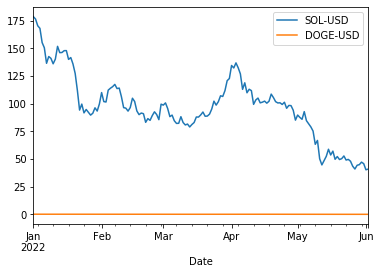

In [11]:
import matplotlib.pyplot as plt
print('correlation=',portfolio2['SOL-USD'].corr(portfolio2['DOGE-USD']))
print('cointegration=',ts.coint(portfolio2['SOL-USD'],portfolio2['DOGE-USD']))
portfolio2[['SOL-USD','DOGE-USD']].copy().plot()

test the stationary of price ratio as spread

In [12]:
import numpy as np
portfolio2['price ratio']=portfolio2['SOL-USD']/portfolio2['DOGE-USD']
portfolio2['log price ratio']=np.log(portfolio2['SOL-USD'])/np.log(portfolio2['DOGE-USD'])

Critical Value =  -3.429060561996766
{'1%': -3.474120870218417, '5%': -2.880749791423677, '10%': -2.5770126333102494}


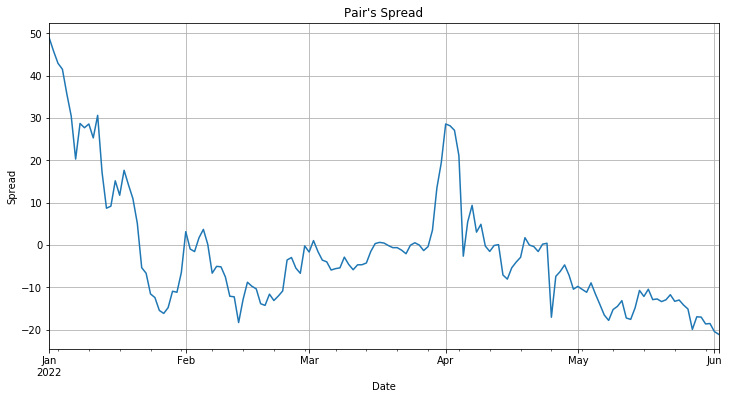

In [13]:
# run OLS regression
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
model=sm.OLS(portfolio2['SOL-USD'], portfolio2['DOGE-USD']).fit()

# calculate spread
spread = portfolio2['SOL-USD'] - model.params[0] * portfolio2['DOGE-USD']

# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);

# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

# probablity critical values
print(adf[4])

portfolio2['spread']=spread

In [14]:
# adf test
from statsmodels.tsa.stattools import adfuller
# adf test for all stock price
stationp=pd.DataFrame(columns=portfolio2.columns)
for column in portfolio2.columns:
    dftest = adfuller(portfolio2[column],autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    result=pd.DataFrame(dfoutput)
    if result.iloc[1,0]<0.05:
        stationp[column]=['stationary']
    else:
        stationp[column]=['not stationary']

In [15]:
stationp

,SOL-USD,DOGE-USD,price ratio,log price ratio,spread
0,not stationary,not stationary,not stationary,not stationary,stationary


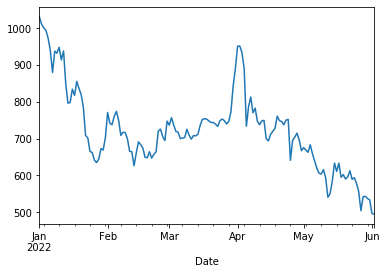

In [16]:
# plot for stock price
portfolio2['price ratio'].plot()

# 2020-2022

In [17]:
# we plan to evaluate the 2-year data 
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2022,1,1)

In [18]:
# pull the data from yahoo finance through this time frame
stocks = ["BNB-USD", "ADA-USD","ETH-USD","LTC-USD","BCH-USD","DOGE-USD","USDT-USD","MATIC-USD","XMR-USD"]
portfolio=combine_stocks(stocks,start,end)

              BNB-USD
Date                 
2020-01-01  13.689083
2020-01-02  13.027011
2020-01-03  13.660452
2020-01-04  13.891512
2020-01-05  14.111019
             ADA-USD
Date                
2020-01-01  0.033458
2020-01-02  0.032751
2020-01-03  0.034180
2020-01-04  0.034595
2020-01-05  0.034721
               ETH-USD
Date                  
2020-01-01  130.802002
2020-01-02  127.410179
2020-01-03  134.171707
2020-01-04  135.069366
2020-01-05  136.276779
              LTC-USD
Date                 
2020-01-01  42.017719
2020-01-02  39.823013
2020-01-03  42.415573
2020-01-04  43.326607
2020-01-05  43.553207
               BCH-USD
Date                  
2020-01-01  204.397537
2020-01-02  195.698563
2020-01-03  222.412979
2020-01-04  226.018692
2020-01-05  224.096527
            DOGE-USD
Date                
2020-01-01  0.002033
2020-01-02  0.002009
2020-01-03  0.002145
2020-01-04  0.002241
2020-01-05  0.002419
            USDT-USD
Date                
2020-01-01  0.999836
2020-01-02  1

In [19]:
# find potentially cointegrated pairs in this newly pulled dataset

y=pd.DataFrame(find_cointegrated_pairs(portfolio)[2])
y

,0,1
0,BNB-USD,MATIC-USD
1,ADA-USD,DOGE-USD
2,USDT-USD,MATIC-USD
3,USDT-USD,XMR-USD


# BNB&MATIC

In [20]:
# test if BNB and MATIC can pass the cointegration test to be used with a pair trading strategy
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks3 = ["MATIC-USD","BNB-USD"]
portfolio3=combine_stocks(stocks3,start,end)

            MATIC-USD
Date                 
2020-01-01   0.014962
2020-01-02   0.014651
2020-01-03   0.015194
2020-01-04   0.014961
2020-01-05   0.014914
              BNB-USD
Date                 
2020-01-01  13.689083
2020-01-02  13.027011
2020-01-03  13.660452
2020-01-04  13.891512
2020-01-05  14.111019
            MATIC-USD    BNB-USD
Date                            
2020-01-01   0.014962  13.689083
2020-01-02   0.014651  13.027011
2020-01-03   0.015194  13.660452
2020-01-04   0.014961  13.891512
2020-01-05   0.014914  14.111019


test if the pair is cointegrated

In [21]:
result = ts.coint(portfolio3['MATIC-USD'],portfolio3['BNB-USD'])
result

(-3.1337173062143986,
 0.08172943152397238,
 array([-3.91146418, -3.34448986, -3.05024907]))

test the stationarity of price ratio

In [22]:
import numpy as np
portfolio3['log price ratio']=np.log(portfolio3['BNB-USD'])/np.log(portfolio3['MATIC-USD'])
portfolio3['price ratio']=portfolio3['BNB-USD']/portfolio3['MATIC-USD']

Critical Value =  -1.7938277451764115
{'1%': -3.439314999916068, '5%': -2.8654965012008677, '10%': -2.5688768817372867}


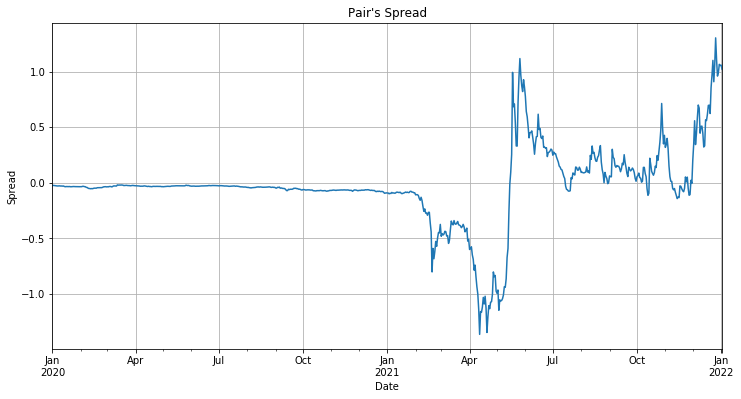

In [23]:
# run OLS regression
model=sm.OLS(portfolio3['MATIC-USD'], portfolio3['BNB-USD']).fit()

# calculate spread
spread = portfolio3['MATIC-USD'] - model.params[0] * portfolio3['BNB-USD']

# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);

# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

# probablity critical values
print(adf[4])

portfolio3['spread']=spread

In [24]:
# adf test
from statsmodels.tsa.stattools import adfuller
# adf test for all stock price
stationp=pd.DataFrame(columns=portfolio3.columns)
for column in portfolio3.columns:
    dftest = adfuller(portfolio3[column],autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    result=pd.DataFrame(dfoutput)
    if result.iloc[1,0]<0.05:
        stationp[column]=['stationary']
    else:
        stationp[column]=['not stationary']

In [25]:
stationp

,MATIC-USD,BNB-USD,log price ratio,price ratio,spread
0,not stationary,not stationary,stationary,not stationary,stationary


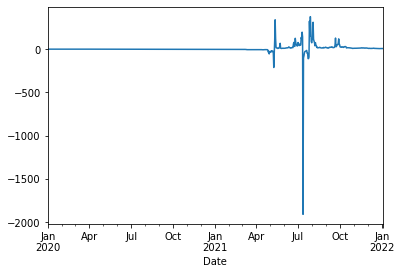

In [26]:
# plot for stock price
portfolio3['log price ratio'].plot()

# ADA&DOGE

In [27]:
# test if ADA and DOGE can pass the cointegration test to be used with a pair trading strategy
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks4 = ["ADA-USD","DOGE-USD"]
portfolio4=combine_stocks(stocks4,start,end)

             ADA-USD
Date                
2020-01-01  0.033458
2020-01-02  0.032751
2020-01-03  0.034180
2020-01-04  0.034595
2020-01-05  0.034721
            DOGE-USD
Date                
2020-01-01  0.002033
2020-01-02  0.002009
2020-01-03  0.002145
2020-01-04  0.002241
2020-01-05  0.002419
             ADA-USD  DOGE-USD
Date                          
2020-01-01  0.033458  0.002033
2020-01-02  0.032751  0.002009
2020-01-03  0.034180  0.002145
2020-01-04  0.034595  0.002241
2020-01-05  0.034721  0.002419


test if it's cointegrated

In [28]:
result = ts.coint(portfolio4['ADA-USD'],portfolio4['DOGE-USD'])
result

(-3.497088736683023,
 0.032654339454708615,
 array([-3.91146418, -3.34448986, -3.05024907]))

In [29]:
portfolio4['price ratio']=portfolio4['ADA-USD']/portfolio4['DOGE-USD']
portfolio4['log price ratio']=np.log(portfolio4['ADA-USD'])/np.log(portfolio4['DOGE-USD'])

Critical Value =  -3.0516824319814626
{'1%': -3.4393273074073045, '5%': -2.8655019247555154, '10%': -2.568879771109793}


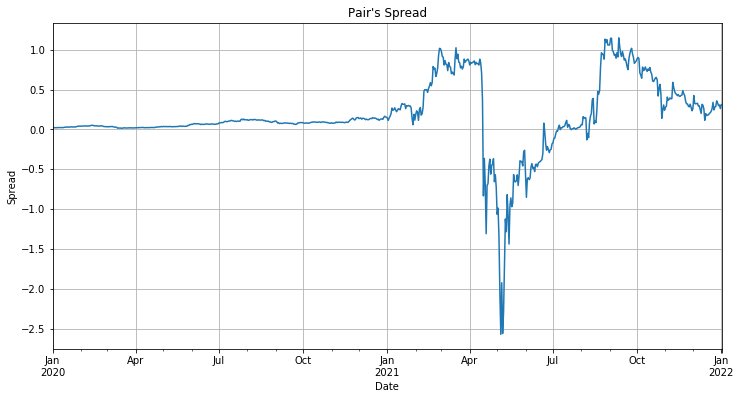

In [30]:
# run OLS regression
model=sm.OLS(portfolio4['ADA-USD'], portfolio4['DOGE-USD']).fit()

# calculate spread
spread = portfolio4['ADA-USD'] - model.params[0] * portfolio4['DOGE-USD']

# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);

# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

# probablity critical values
print(adf[4])

portfolio4['spread']=spread

In [31]:
# adf test
from statsmodels.tsa.stattools import adfuller
# adf test for all stock price
stationp=pd.DataFrame(columns=portfolio4.columns)
for column in portfolio4.columns:
    dftest = adfuller(portfolio4[column],autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    result=pd.DataFrame(dfoutput)
    if result.iloc[1,0]<0.05:
        stationp[column]=['stationary']
    else:
        stationp[column]=['not stationary']

In [32]:
stationp

,ADA-USD,DOGE-USD,price ratio,log price ratio,spread
0,not stationary,not stationary,not stationary,not stationary,stationary


# 2021-2022

In [33]:
start = datetime.datetime(2021,6,1)
end = datetime.datetime(2022,1,1)

In [34]:
# pull data across 10 selected altcoins from yahoo finance through this time frame
stocks = ["BNB-USD", "ADA-USD","ETH-USD","LTC-USD","BCH-USD","DOGE-USD","USDT-USD","MATIC-USD","XMR-USD"]
portfolio=combine_stocks(stocks,start,end)

               BNB-USD
Date                  
2021-06-01  362.794647
2021-06-02  401.262329
2021-06-03  427.807922
2021-06-04  391.395325
2021-06-05  390.431854
             ADA-USD
Date                
2021-06-01  1.734753
2021-06-02  1.752824
2021-06-03  1.840471
2021-06-04  1.710908
2021-06-05  1.659009
                ETH-USD
Date                   
2021-06-01  2633.518311
2021-06-02  2706.125000
2021-06-03  2855.126465
2021-06-04  2688.195068
2021-06-05  2630.576904
               LTC-USD
Date                  
2021-06-01  182.980698
2021-06-02  187.263977
2021-06-03  193.086182
2021-06-04  178.872009
2021-06-05  173.028717
               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
            DOGE-USD
Date                
2021-06-01  0.370077
2021-06-02  0.423374
2021-06-03  0.399963
2021-06-04  0.376323
2021-06-05  0.372177
            USDT-USD
Date                
2021-06-01  1

In [35]:
# find potential cointegrated pairs through this time frame
y=pd.DataFrame(find_cointegrated_pairs(portfolio)[2])
y

,0,1
0,BCH-USD,XMR-USD
1,USDT-USD,MATIC-USD
2,USDT-USD,XMR-USD


# BCH&XMR

In [36]:
# test if BCH and XMR can pass the cointegration test to be used with a pair trading strategy
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
portfolio5=combine_stocks(stocks5,start,end)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


In [37]:
result = ts.coint(portfolio5['BCH-USD'],portfolio5['XMR-USD'])
result

(-4.012055652282486,
 0.006902110133543827,
 array([-3.94810437, -3.36469667, -3.06423535]))

correlation= 0.9020319539285295
cointegration= (-4.012055652282486, 0.006902110133543827, array([-3.94810437, -3.36469667, -3.06423535]))


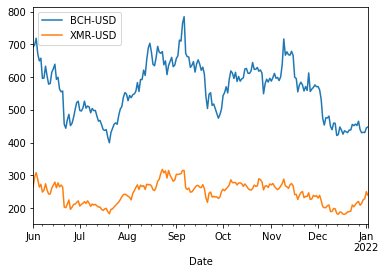

In [38]:
print('correlation=',portfolio5['BCH-USD'].corr(portfolio5['XMR-USD']))
print('cointegration=',ts.coint(portfolio5['BCH-USD'],portfolio5['XMR-USD']))
portfolio5[['BCH-USD','XMR-USD']].copy().plot()

In [39]:
portfolio5['price ratio']=portfolio5['BCH-USD']/portfolio5['XMR-USD']
portfolio5['log price ratio']=np.log(portfolio5['BCH-USD'])/np.log(portfolio5['XMR-USD'])

Critical Value =  -3.410490692021465
{'1%': -3.461136478222043, '5%': -2.875078880098608, '10%': -2.5739861168199027}


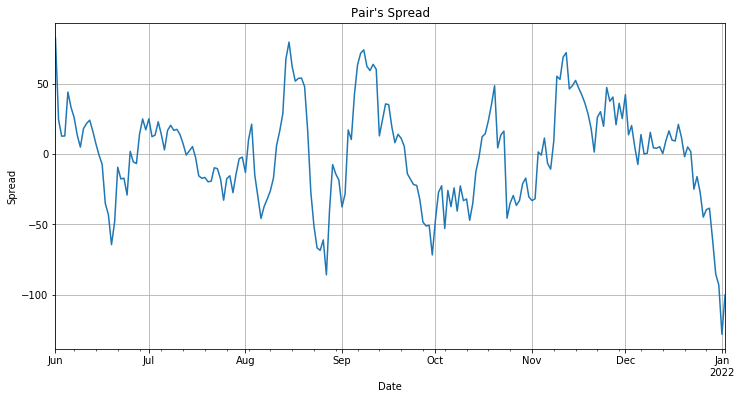

In [40]:
# run OLS regression
model=sm.OLS(portfolio5['BCH-USD'], portfolio5['XMR-USD']).fit()

# calculate spread
spread = portfolio5['BCH-USD'] - model.params[0] * portfolio5['XMR-USD']

# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);

# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

# probablity critical values
print(adf[4])

portfolio5['spread']=spread

In [41]:
# adf test
from statsmodels.tsa.stattools import adfuller
# adf test for all stock price
stationp=pd.DataFrame(columns=portfolio5.columns)
for column in portfolio5.columns:
    dftest = adfuller(portfolio5[column],autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    result=pd.DataFrame(dfoutput)
    if result.iloc[1,0]<0.05:
        stationp[column]=['stationary']
    else:
        stationp[column]=['not stationary']

In [42]:
stationp

,BCH-USD,XMR-USD,price ratio,log price ratio,spread
0,not stationary,not stationary,stationary,stationary,stationary


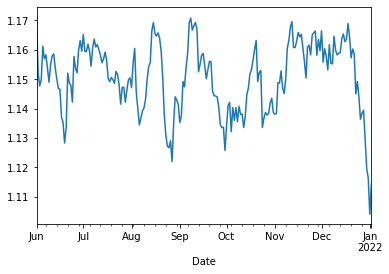

In [43]:
# plot for stock price
portfolio5['log price ratio'].plot()